This notebook combines the work of [this blog post](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf) from Tarek Ghanoum on topic modeling in Python with SpaCy and Gensim, along with [this blog post](https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/#topic=6&lambda=1&term=) from Jeri E. Wieringa on topic modeling over time. The model is also made using HT data, pulled from [this workset](https://proxy.htrc.indiana.edu/worksets/htrc/United%20States%20Presidential%20Speeches%20(1970s)) of United States Presidential speeches from the 1970s.

In [ ]:
%pip install gensim
%pip install ggplot
%pip install json
%pip install logging
%pip install matplotlib
%pip install os
%pip install pandas
%pip install pyLDAvis
%pip install seaborn
%pip install warnings

In [152]:
from ggplot import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

import pyLDAvis.gensim_models
import en_core_web_md

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

Next, we need to select a portion of the workset to analyze and create the metadata table for that portion, which includes the name of each document, the year it comes from, and some statistics on each topic within each document. `topic_weight` is the probability that a document belongs to a topic, and `topic_words` is the five most common words in a topic, for the purposes of labeling plots we'll generate later. Data can be downloaded from [here](https://github.com/thomdaro/htrc-misc/tree/main/texts).

In [175]:
PERCENTAGE_OF_DATA = 100     # determines how much of the dataset to use. 100% takes a very long time to generate a model, even on my machine
NUM_TOPICS = 14              # can be changed depending on plot of coherence vs. number of topics

data = []
top_dir_name = "D:/Work/HTRC/Notebooks/texts"   # change this to wherever you put the data
sub_dir_names = ["1971", "1972", "1973", "1974a", "1974b", "1975a", "1975b", "1976a", "1976b", "1976c", "1977a", "1977b", "1978a", "1978b", "1979a", "1979b"] 
df = pd.DataFrame(columns=['topic_id', 'topic_weight', 'topic_words', 'doc_id', 'year'])

for sub_dir_name in sub_dir_names:
    
    dir_name = top_dir_name + '/' + sub_dir_name
    dir = os.fsencode(dir_name)

    for file in os.listdir(dir):
        
        if random.randrange(0, 100) > PERCENTAGE_OF_DATA:
            continue
        
        file_name = os.fsdecode(file)
        page = ''
        
        with open(dir_name + '/' + file_name) as f_open:
            while True:
                try:
                    line = f_open.readline()
                    if line == '':
                        break
                    page += line
                except UnicodeDecodeError:
                    continue
                
        data.append(page)
        
        # topic_weight and topic_words will be filled in after the model is generated
        for n in range(NUM_TOPICS):
            df.loc[len(df.index)] = [n+1, 0, '', file_name, int(file_name[:4])]

df.head()

,topic_id,topic_weight,topic_words,doc_id,year
0,1,0,,1971-0001.txt,1971
1,2,0,,1971-0001.txt,1971
2,3,0,,1971-0001.txt,1971
3,4,0,,1971-0001.txt,1971
4,5,0,,1971-0001.txt,1971


From here, we load SpaCy's NLP module, pipe the data through it, and remove any tokens classified as any of the parts of speech in `removal`.

In [176]:
nlp = en_core_web_md.load()

removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for doc in nlp.pipe(data):
   proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

Using our cleaned-up token array, we can create a dictionary that filters out terms in fewer than 5% of documents, or more than 50% of documents, and limits the vocabulary to 1000 words. We can easily create a corpus from this filtered dictionary.

In [177]:
dictionary = Dictionary(tokens)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
corpus = [dictionary.doc2bow(doc) for doc in tokens]

This cell generates models with 1 to 15 topics, then calculates the coherence of each model and plots the coherence vs. the number of topics used. From there, we can choose the number of topics with the highest coherence.

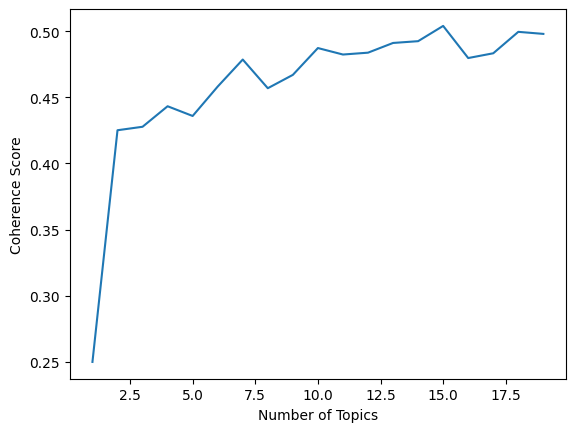

In [174]:
topics = []
scores = []

for i in range(1,20):

    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers=8, passes=10, random_state=100)
    
    cm = CoherenceModel(model=lda_model, texts=tokens, corpus=corpus, dictionary=dictionary, coherence='c_v')
    
    topics.append(i)
    scores.append(cm.get_coherence())

_=plt.plot(topics, scores)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

From here, we generate a model with the optimal topic number in `num_topics`. `workers` indicates how many CPU cores to use – if you're not sure, try 4 or maybe 2.

In [182]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=NUM_TOPICS, workers=8, passes=100)

Now that we have a model, we can get a `topic_weight` and `topic_words` for every topic against every document. because the topic weights are already probabilities, they're normalized to be between 0 and 1 by default, which will be important for plotting later.

In [196]:
topics = [lda_model[corpus][text] for text in range(len(data))]

for n in range(len(topics)):
    
    for k in range(NUM_TOPICS):
        words = ''
        for term in lda_model.show_topic(k, topn=5):
            words += term[0] + ', '
        df.at[n * NUM_TOPICS + k, 'topic_words'] = words[:-2]
        
    for m in range(len(topics[n])):
        topic = topics[n][m]
        df.at[n * NUM_TOPICS + topic[0], 'topic_weight'] = topic[1]

We can use `pyLDAvis` to visualize the model and view our topics, although it seems like the topic numbers in the visualization don't match up with the model. Looking into fixing this.

In [184]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

Using topic weights, we can see some statistics on how topics are represented in the data.

In [185]:
df_sum = df[df['topic_weight'] != 0]

print("Max: {}".format(df_sum['topic_weight'].max()))
print("Min: {}".format(df_sum['topic_weight'].min()))
print("Average: {}".format(df_sum['topic_weight'].mean()))
print("Median: {}".format(df_sum['topic_weight'].median()))
print("Most frequent value: {}".format(df_sum['topic_weight'].round(3).value_counts().idxmax()))

Max: 0.9960981607437134
Min: 0.010024912655353546
Average: 0.19683544112884507
Median: 0.11659730598330498
Most frequent value: 0.071


From here, we can generate some plots to view topics over time in the dataset. The category plot below looks nice, but it's not the easiest to interpret.

Text(0.5, 0.98, 'Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.')

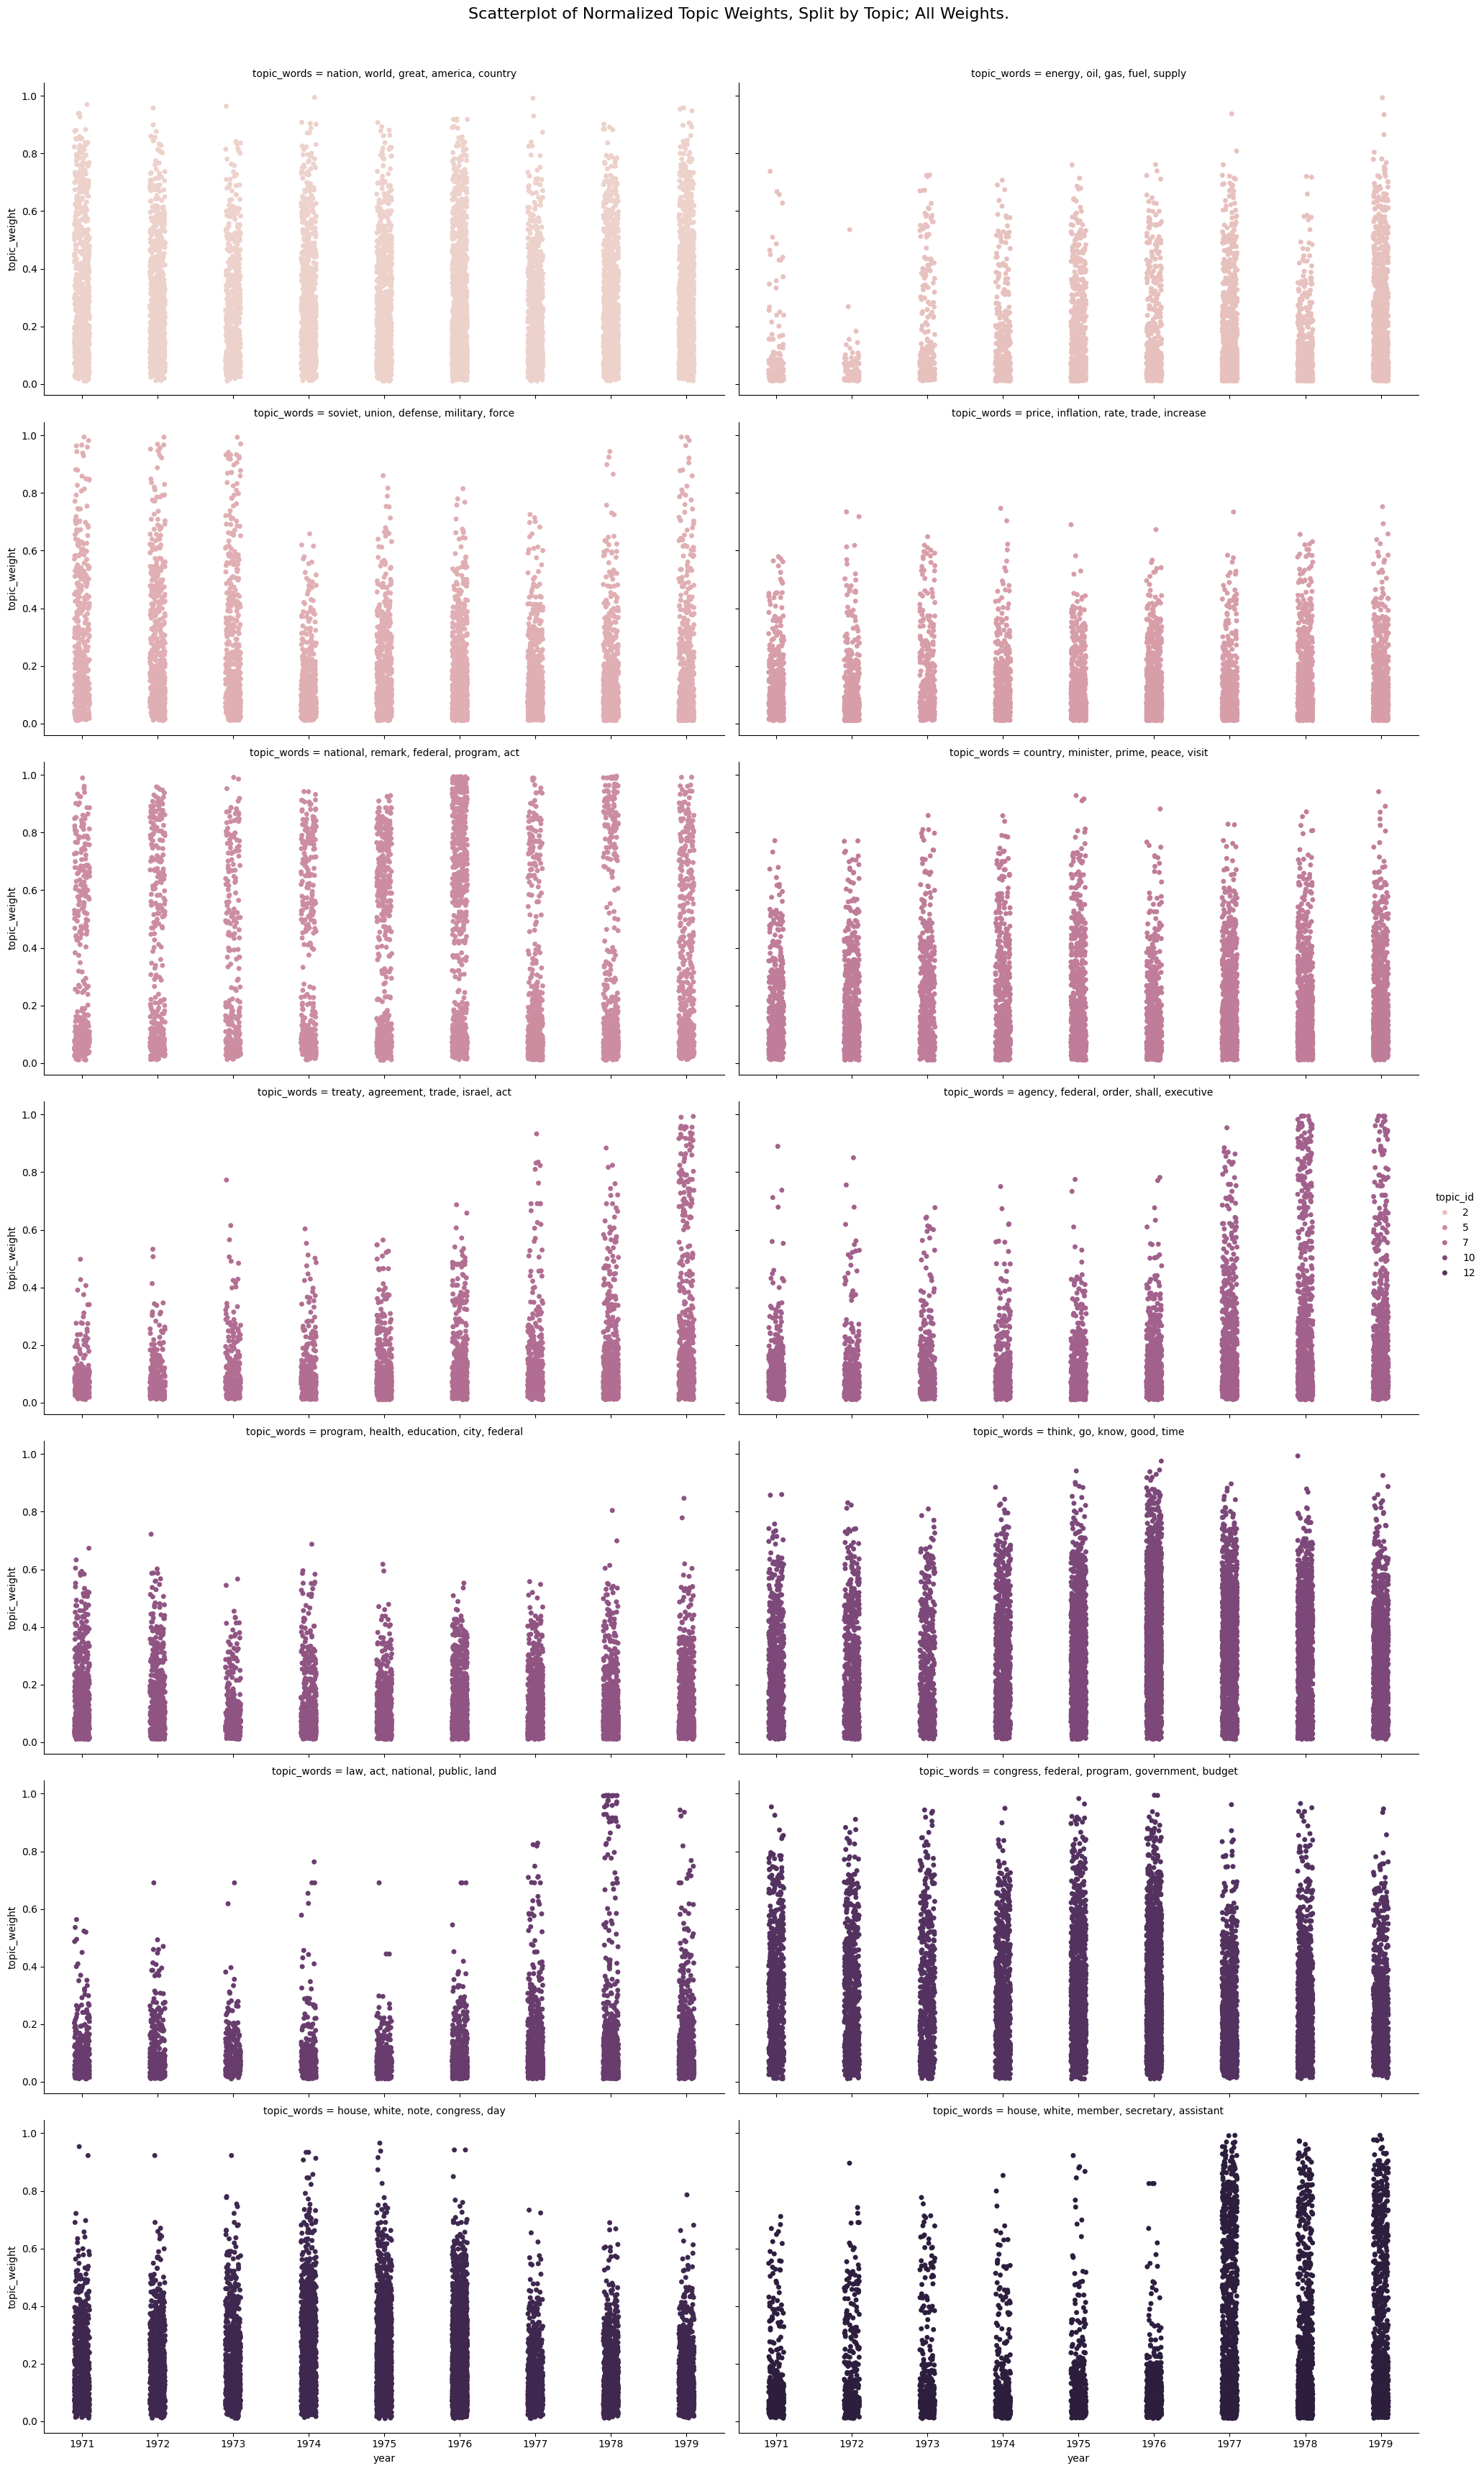

In [186]:
p = sns.catplot(x="year", y='topic_weight', hue="topic_id", col='topic_words', col_wrap=2, kind='strip', size=5, aspect=2, jitter=0.1, data=df_sum)
p.figure.subplots_adjust(top=0.95)
p.figure.suptitle("Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.", fontsize=16)

In [187]:
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, height=5, aspect=1.5, title=""):
    p = sns.catplot(x="year", y=y_value, kind='point', hue=hue, col=col, col_wrap=wrap, height=height, aspect=aspect, errorbar=('ci', 40), data=df)
    p.figure.subplots_adjust(top=0.9)
    p.figure.suptitle(title, fontsize=16)
    return p

def create_bar(df, y_value, hue=None, col=None, wrap=None, aspect=1.5, title=""):
    p = sns.catplot(x="year", y=y_value, kind='bar', hue=hue, col=col, col_wrap=wrap, aspect=aspect, data=df)
    p.figure.subplots_adjust(top=0.9)
    p.figure.suptitle(title, fontsize=16)
    return p

This plot uses seaborn to show the range of topic weights, per topic, per year.

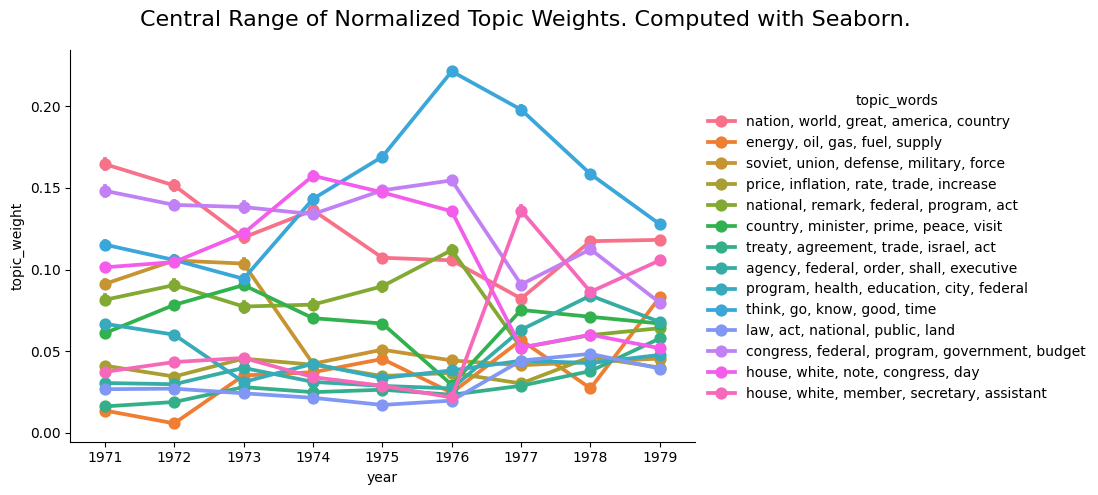

In [188]:
create_pointplot(df, 'topic_weight', hue='topic_words', height=5, aspect=1.5, title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

And this one separates the topics out individually.

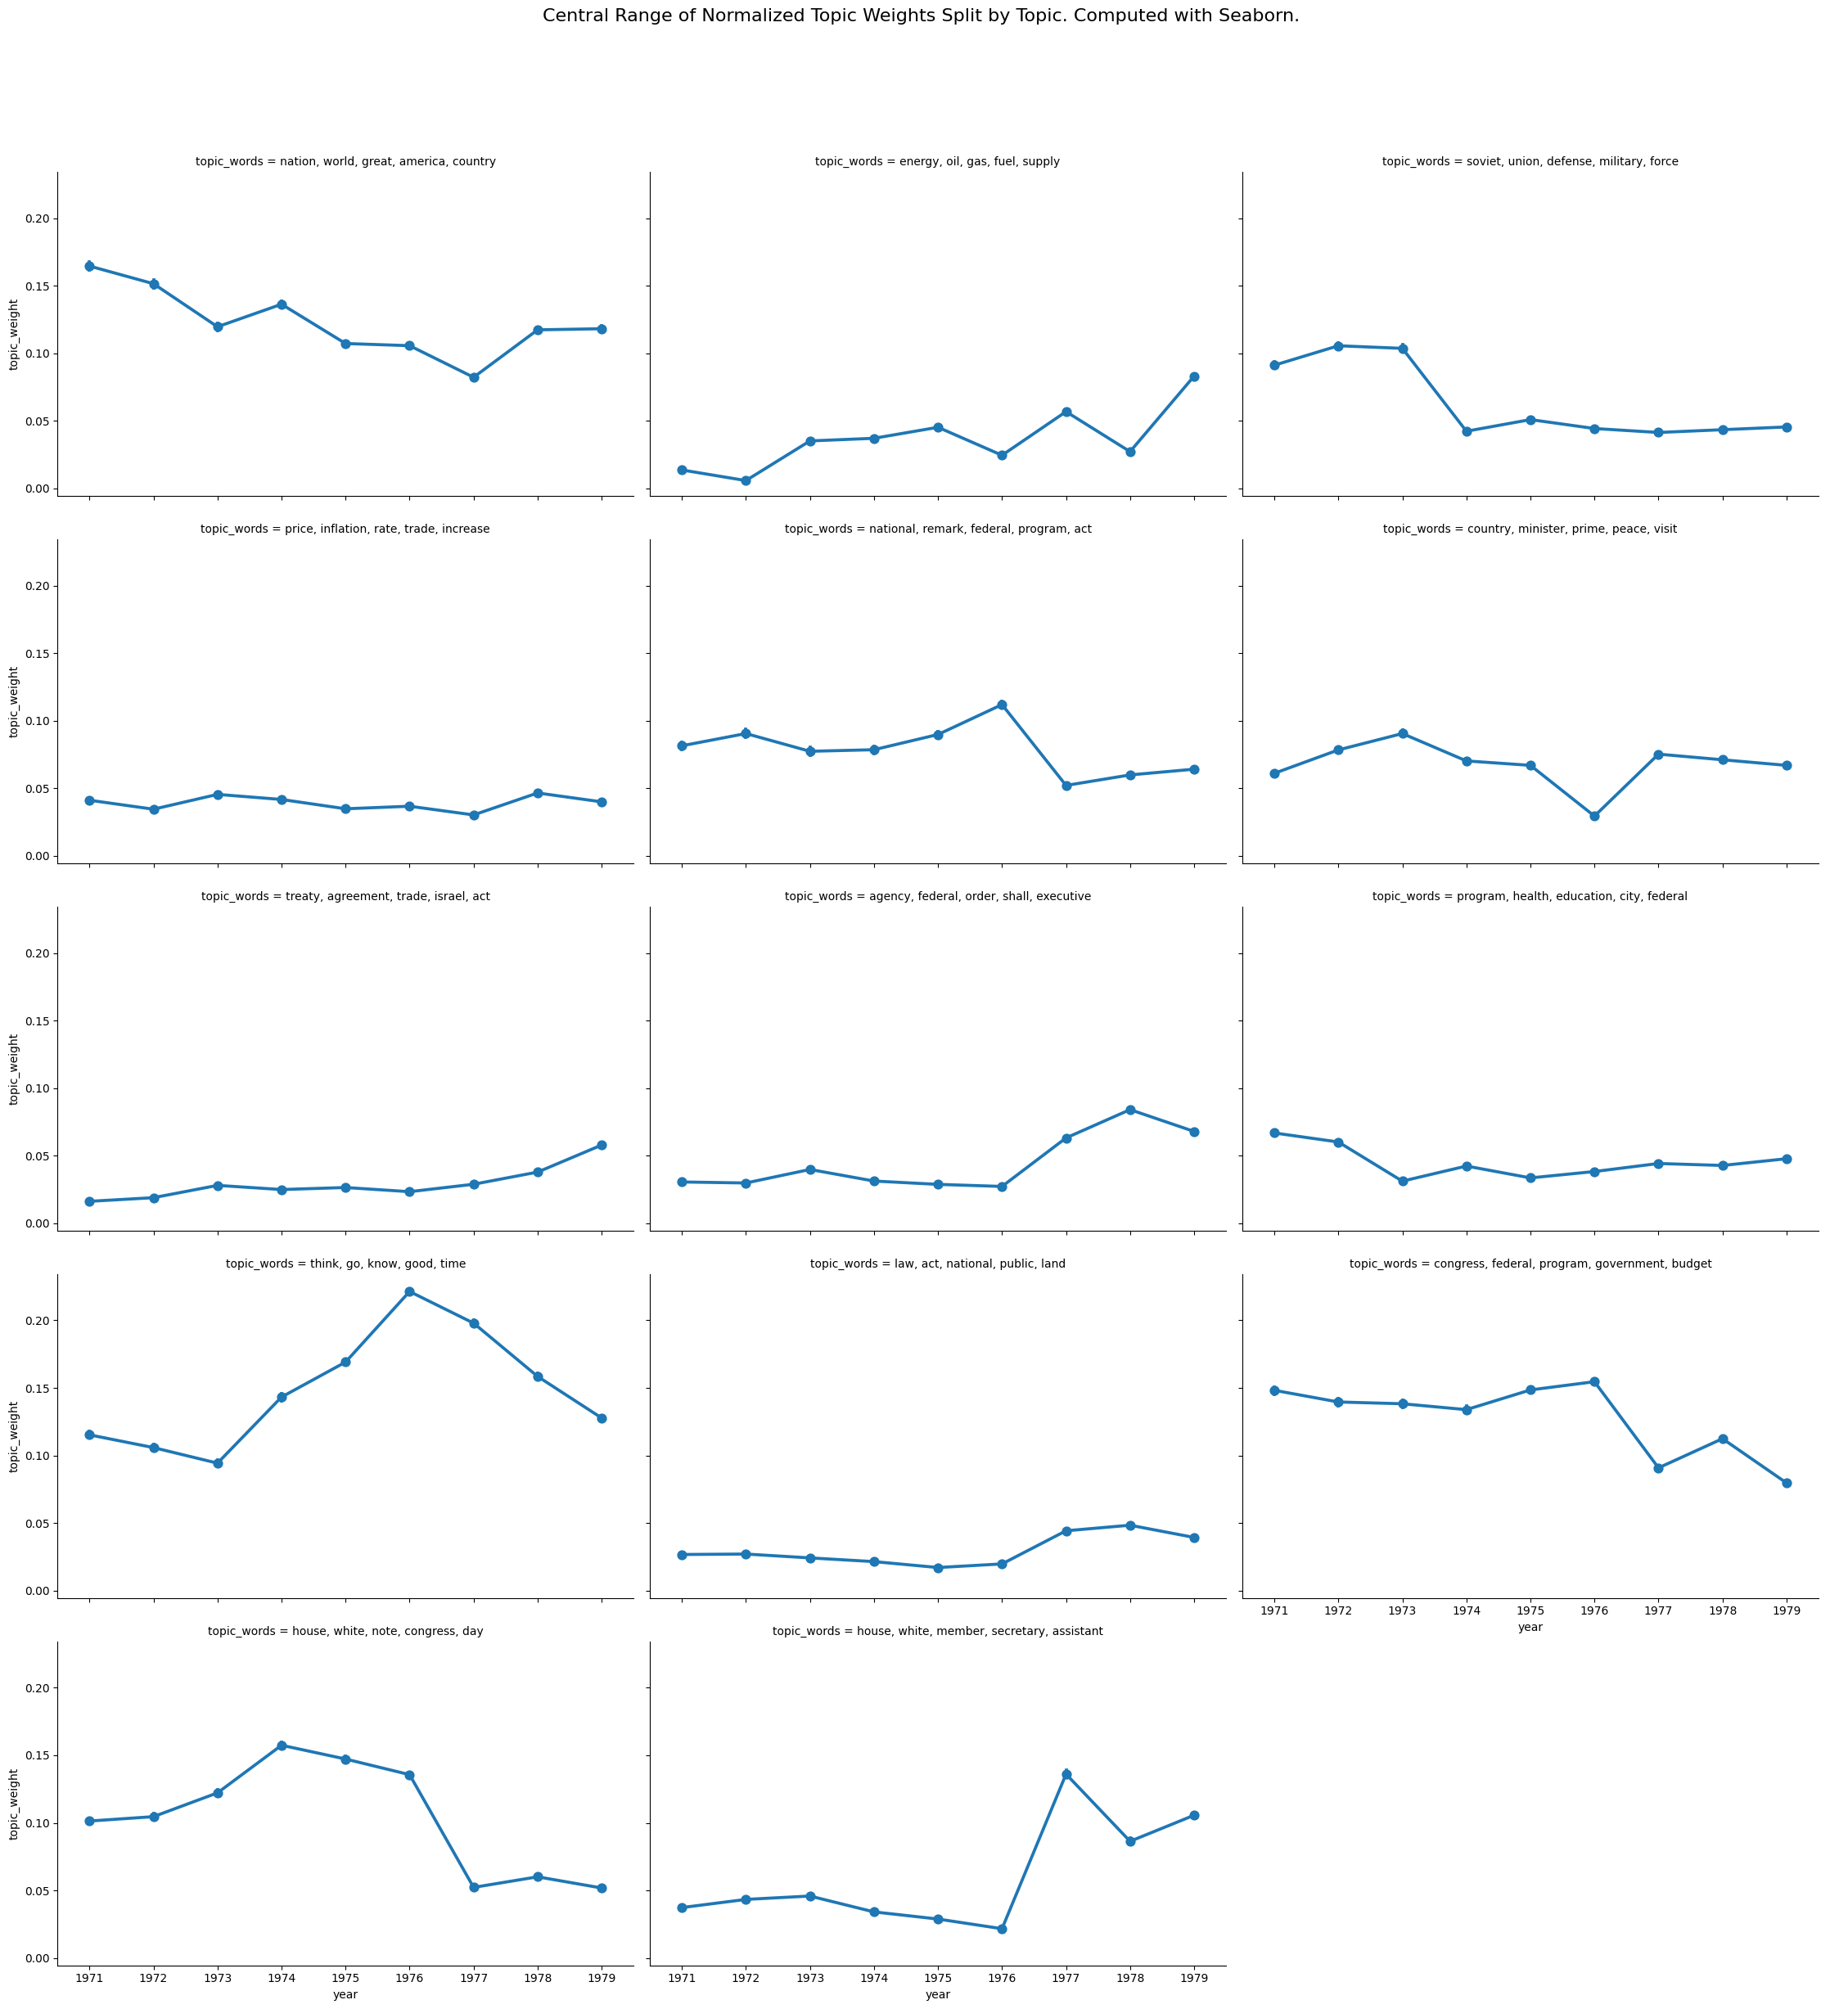

In [189]:
create_pointplot(df, 'topic_weight', col='topic_words', wrap=3, title="Central Range of Normalized Topic Weights Split by Topic. Computed with Seaborn.")

This code computes the topic weight averages manually, so that we don't have to deal with ranges / error bars and can get a precise number for each average.

In [191]:
total_docs = df.groupby('year')['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year', 'total_docs']

df_avg = df.groupby(['year', 'topic_id']).agg({'topic_weight': 'sum'}).reset_index()
df_avg = df_avg.merge(total_docs, on="year", how="left")
df_avg['average_weight'] = df_avg['topic_weight'] / df_avg['total_docs']
df_avg['topic_words'] = df['topic_words']

The two plots below are identical to the above, just using manual calculations rather than seaborn.

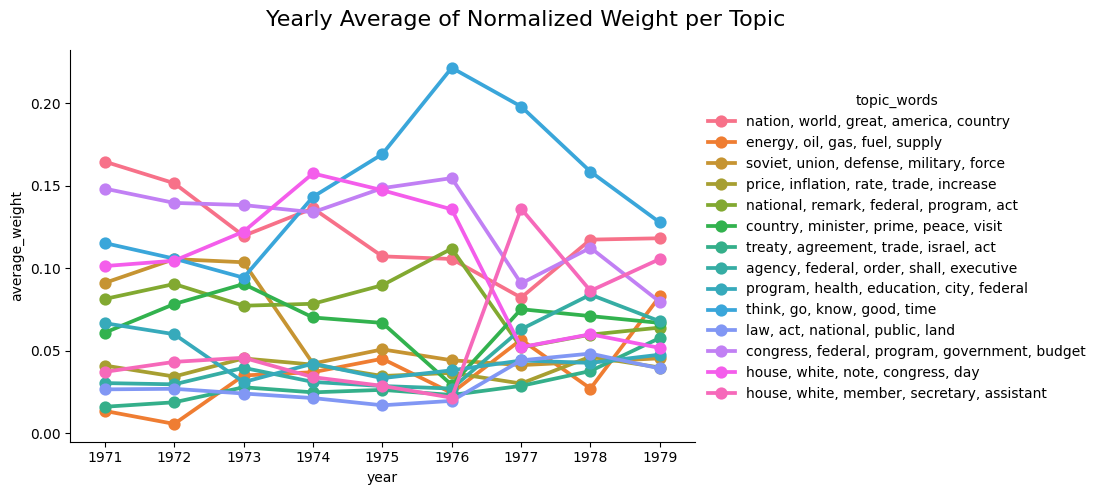

In [192]:
create_pointplot(df_avg, 'average_weight', hue="topic_words", title="Yearly Average of Normalized Weight per Topic")

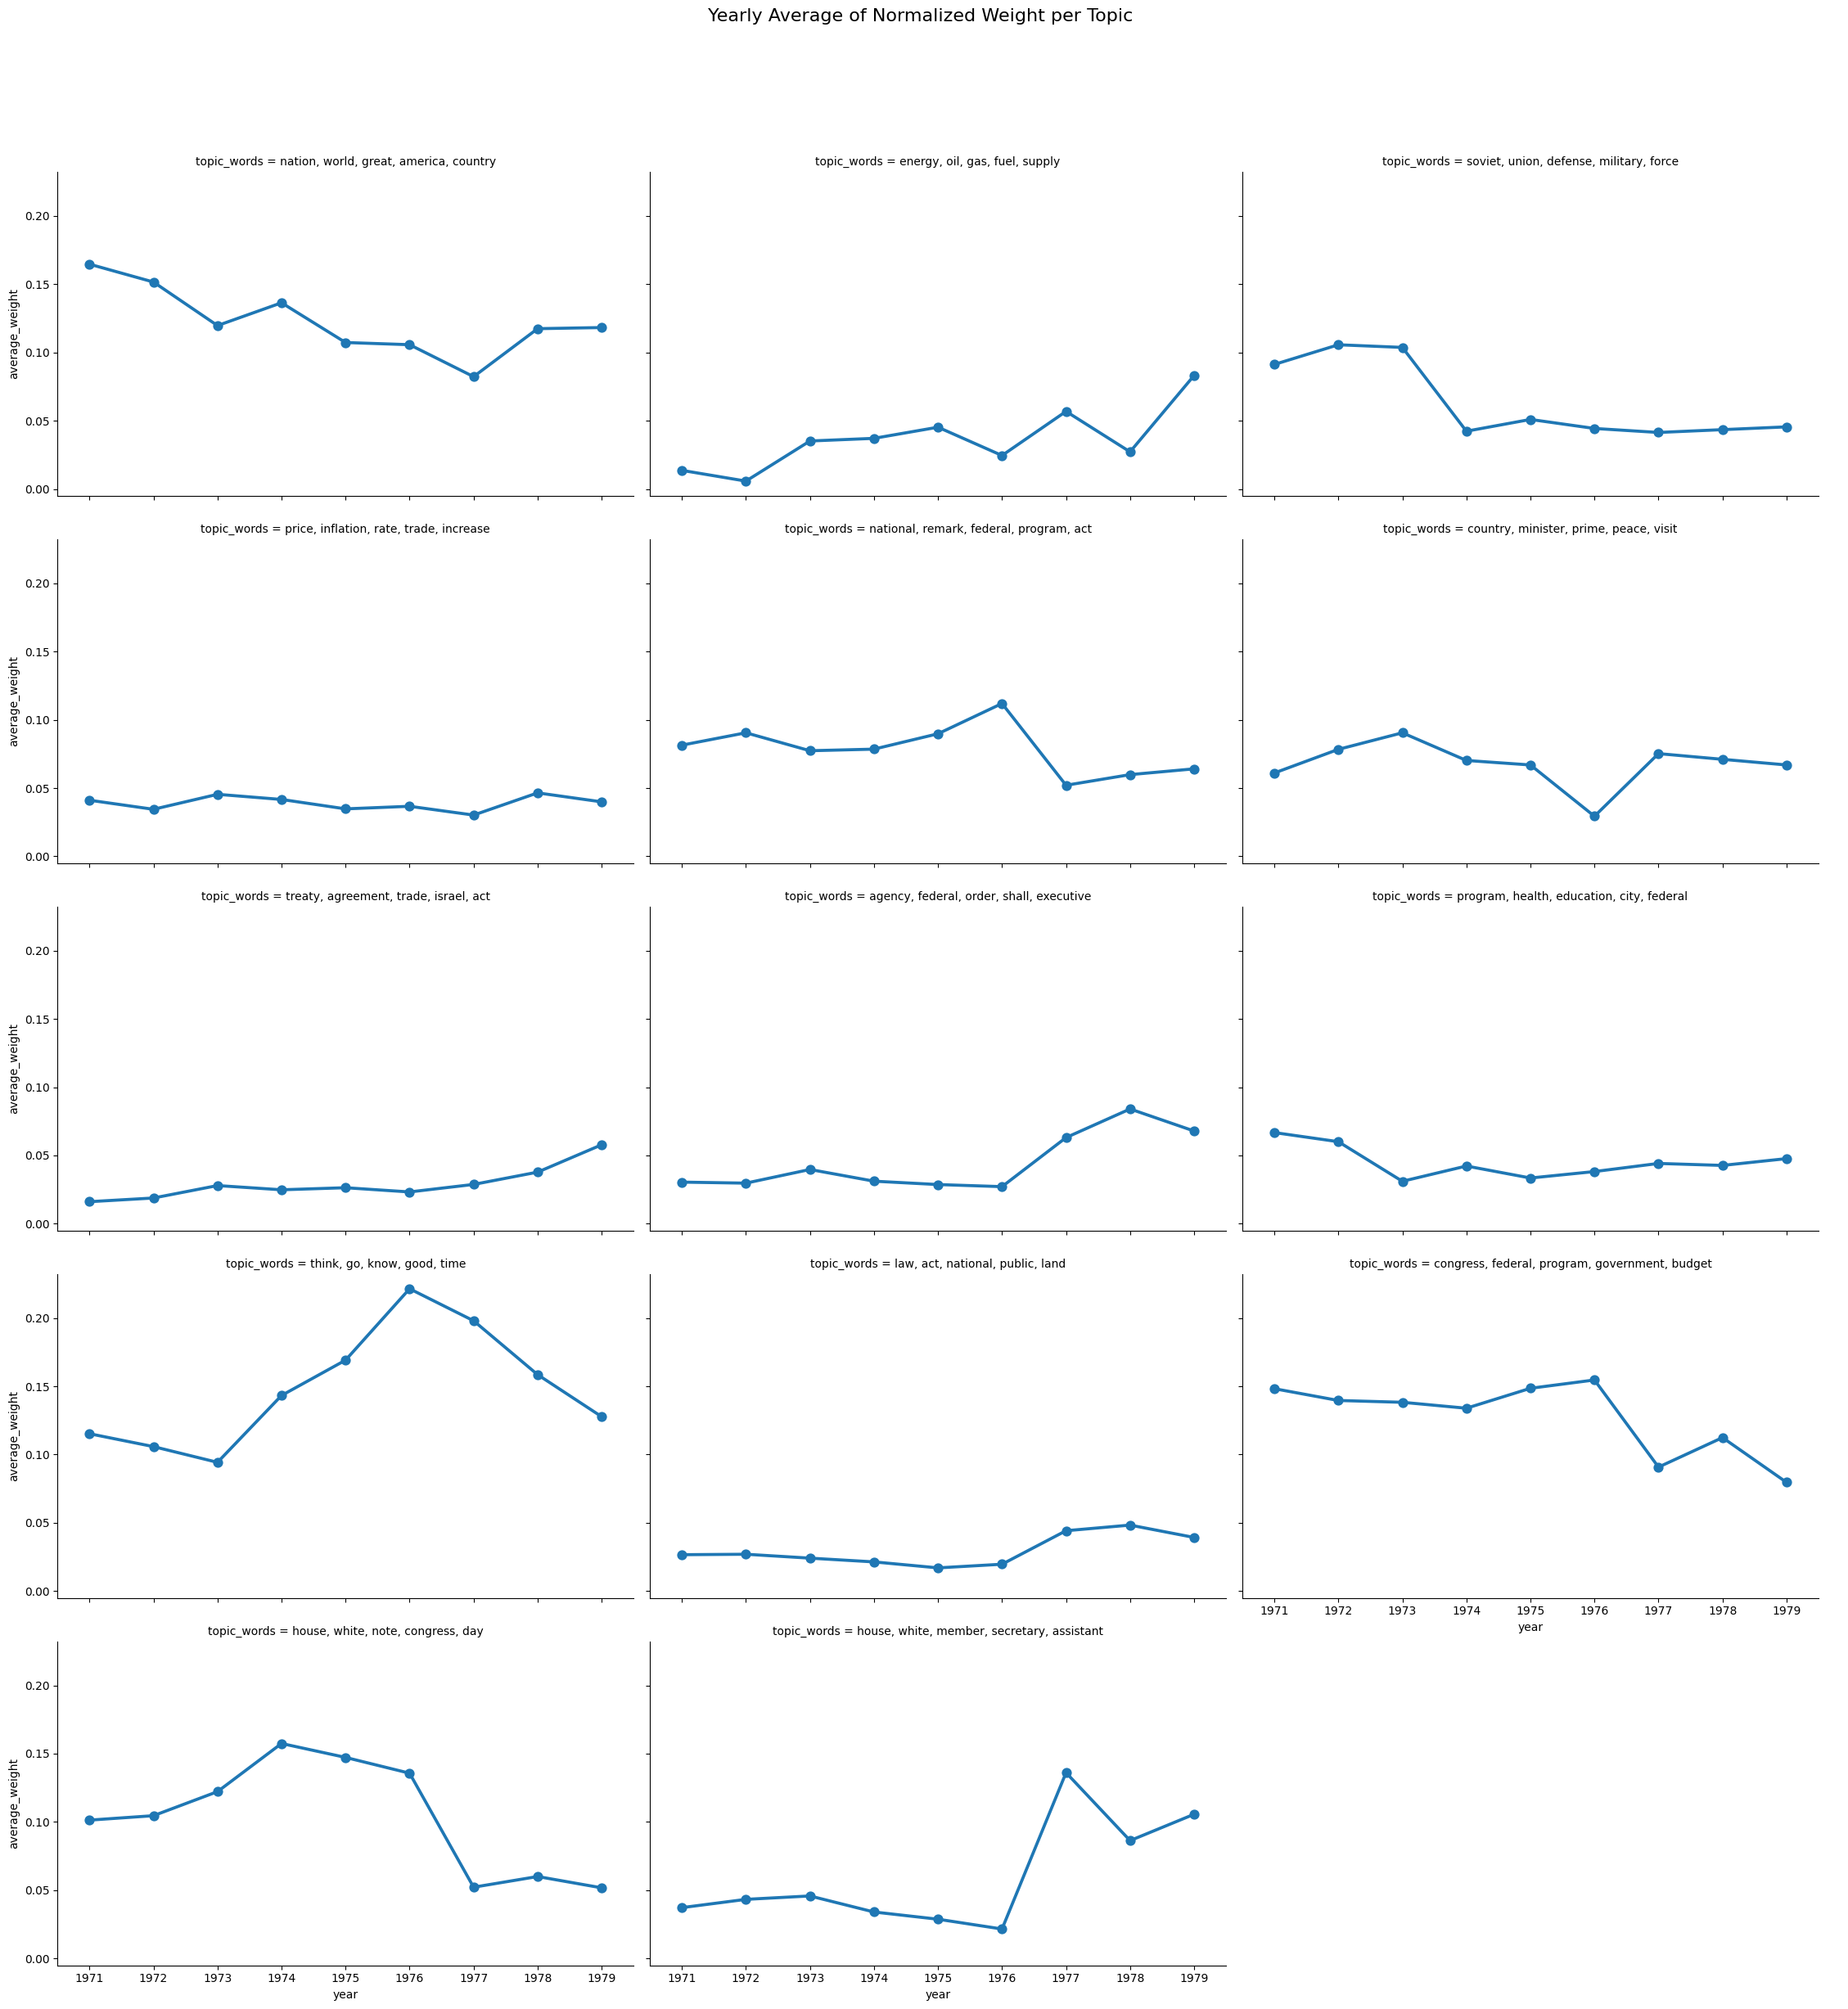

In [193]:
create_pointplot(df_avg, 'average_weight', col="topic_words", wrap=3, title="Yearly Average of Normalized Weight per Topic")

And these plots are similar in concept, but bar graphs allow us to view each year as a discrete chunk of time, and it's a little easier to compare topics against each other this way.

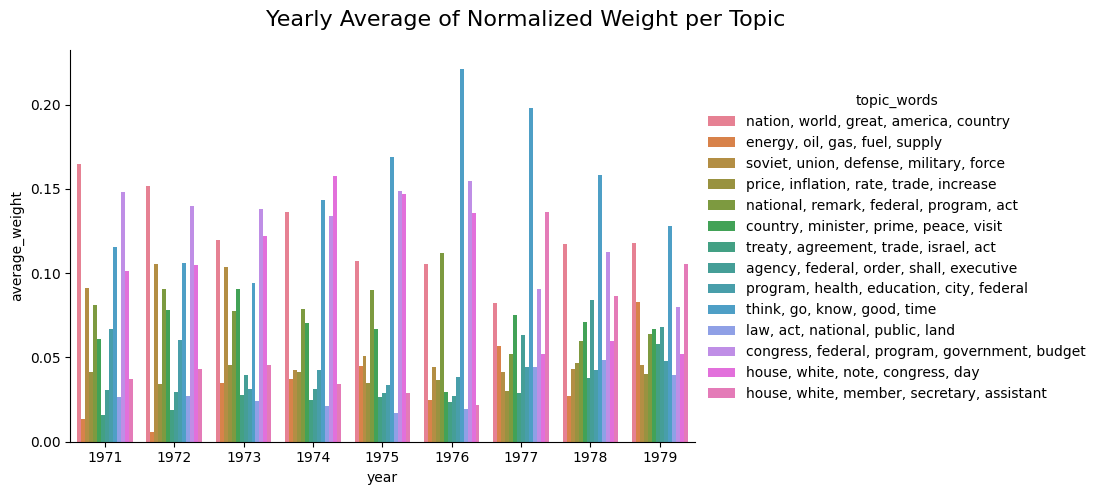

In [194]:
create_bar(df_avg, 'average_weight', hue="topic_words", title="Yearly Average of Normalized Weight per Topic")

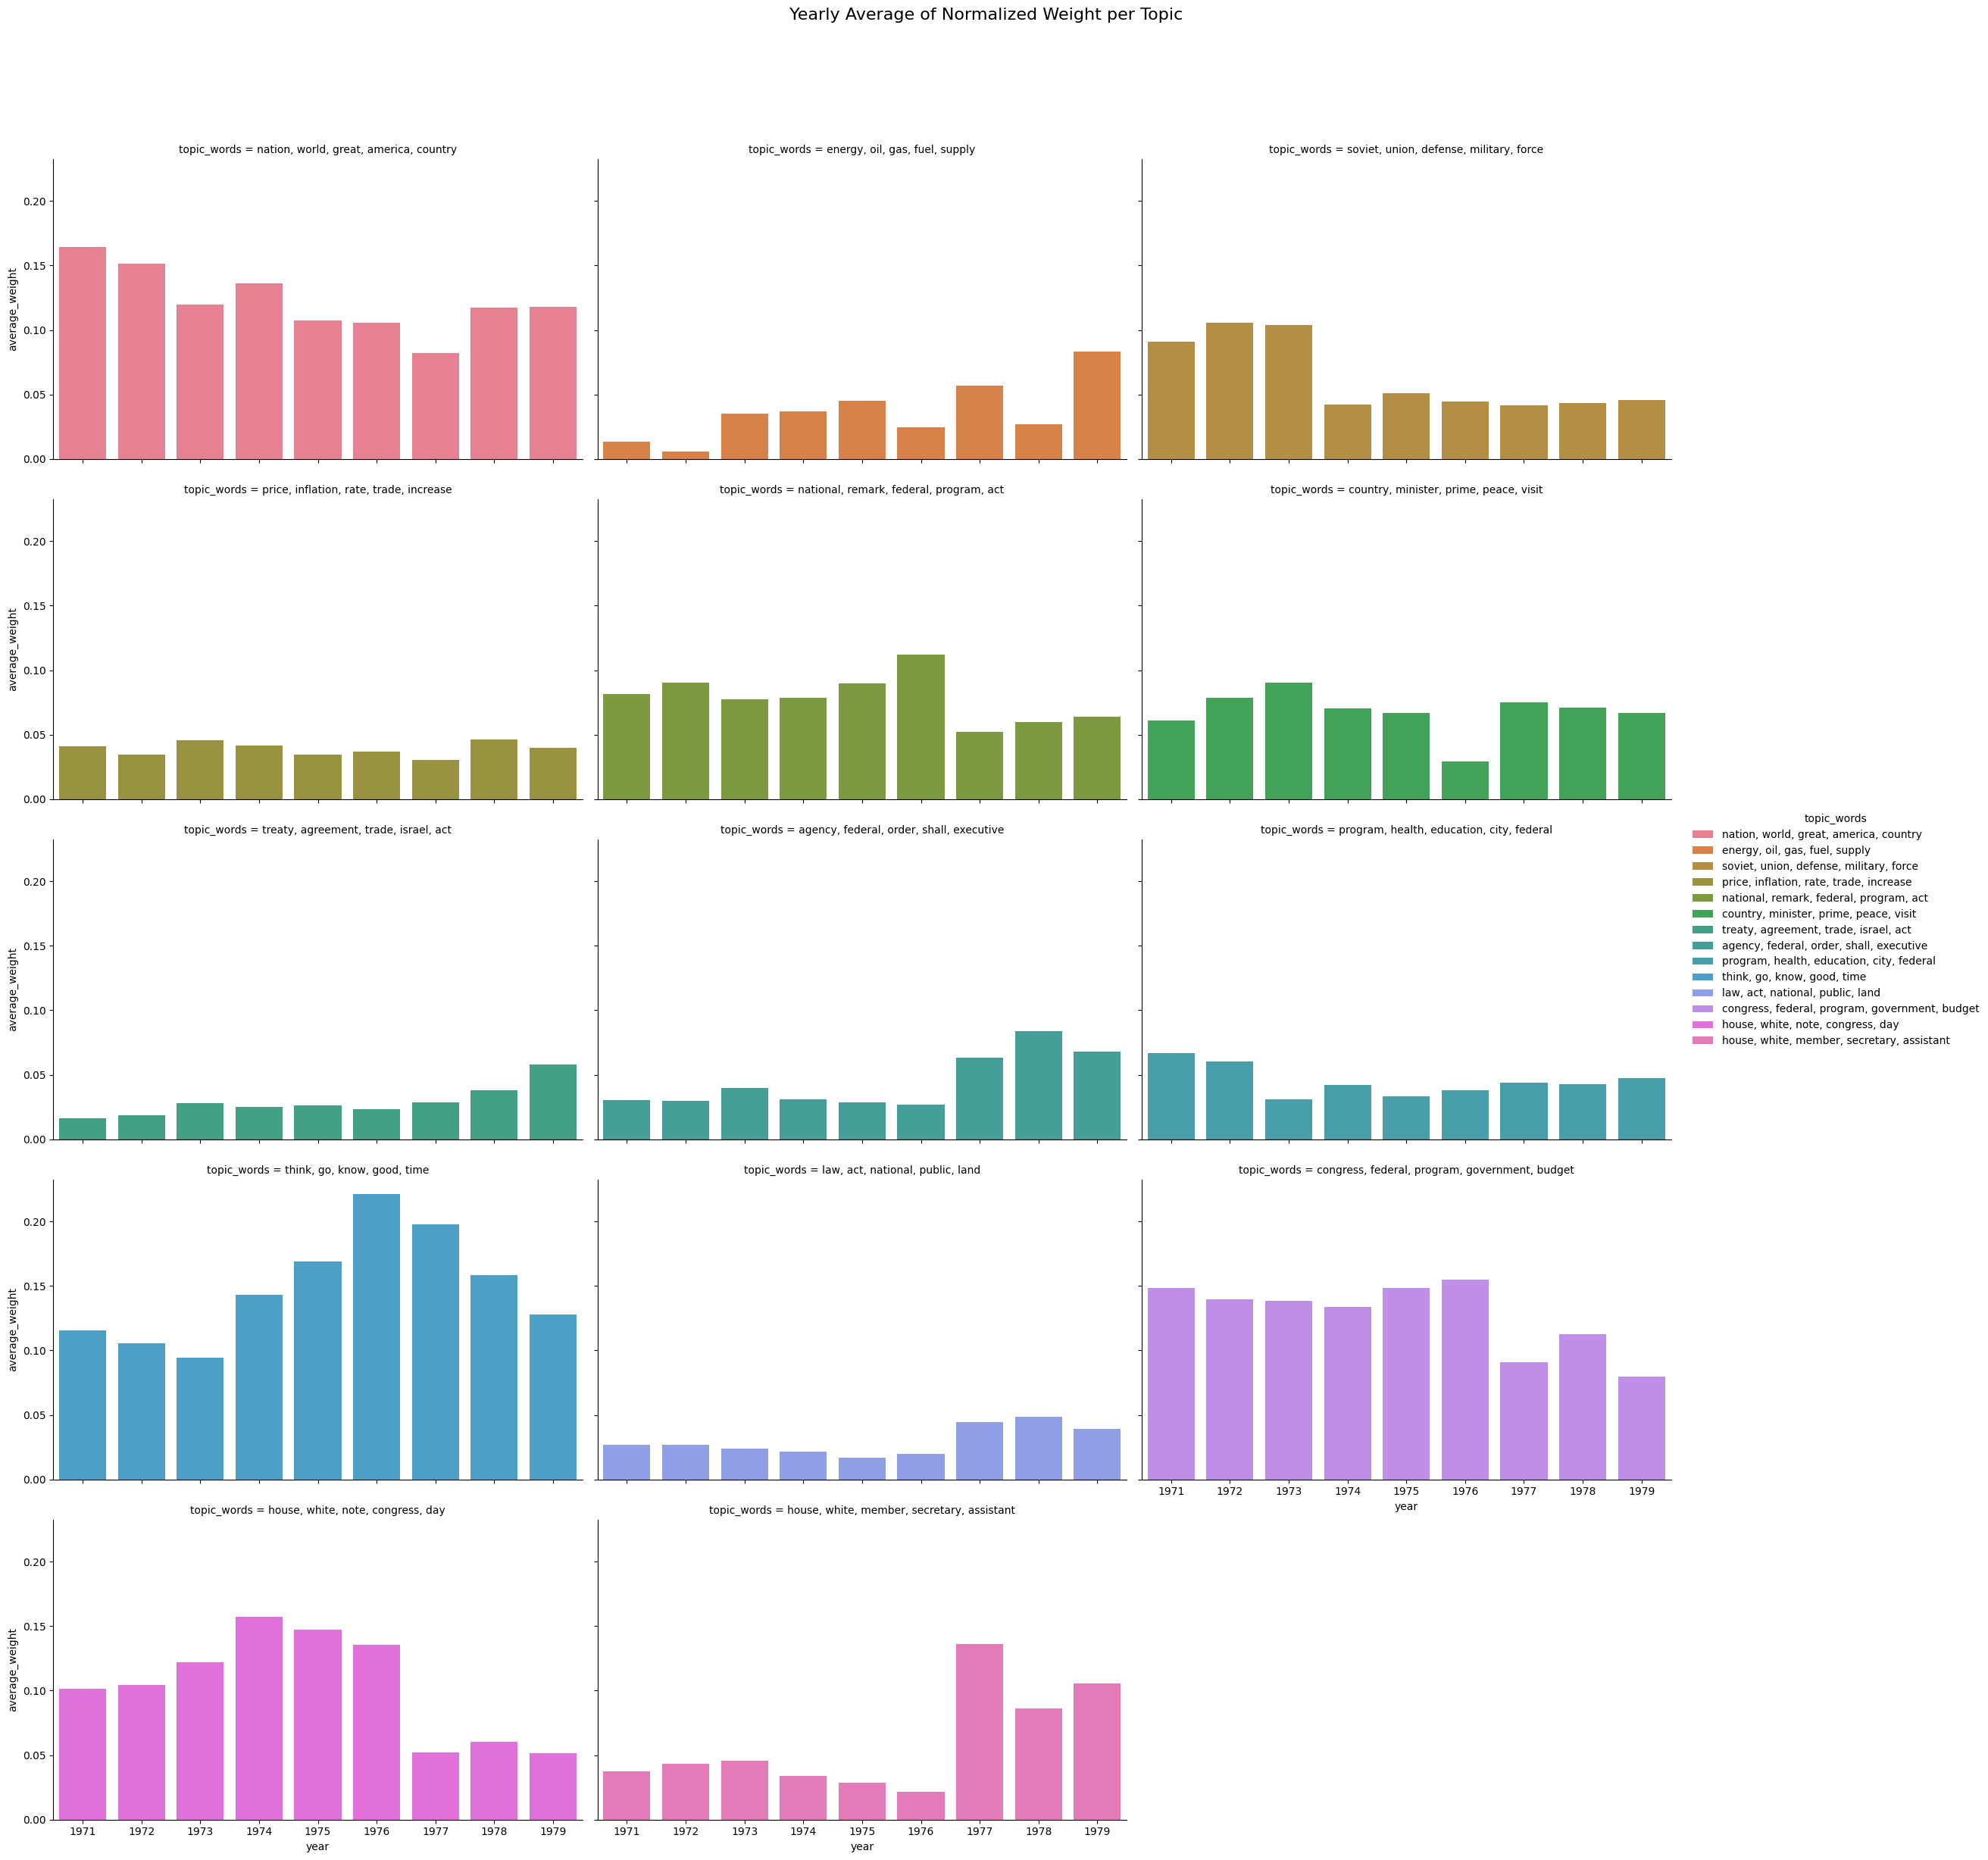

In [195]:
create_bar(df_avg, 'average_weight', hue="topic_words", col='topic_words', wrap=3, title="Yearly Average of Normalized Weight per Topic")